# Read dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_data = pd.read_csv('./dataset/Google_Stock_Price_Train.csv').values
test_data = pd.read_csv('./dataset/Google_Stock_Price_Test.csv').values

# parameter
input_days = 10
local_norm_flag = True
epochs = 1000
batch_size = 500
period = 100
offset = 0.5
RADAM = False
if RADAM:
    from keras_radam import RAdam
    from keras_lookahead import Lookahead
    optimizer = Lookahead(RAdam())
else:
    optimizer = 'sgd'

# Fix data string to float

In [2]:
# the data[4:6] must be fix
def str2float(data):
    length = len(data)
    for i in range(length):
        try:
            data[i] = data[i].replace(',', '')
        except AttributeError:
            data[i] = data[i]
    return np.asarray(data, dtype=np.float)
    
# fix all data in dataset
def fixStr2Float(dataset):
    shape = dataset.shape
    dataset_t = np.zeros((0, shape[-1]), np.float)
    for i, data in enumerate(dataset):
        dataset_t = np.append(dataset_t, np.expand_dims(str2float(data), axis=0), axis=0)
    return dataset_t

# trainsform
train_data_t = fixStr2Float(train_data[:, 1:])
test_data_t = fixStr2Float(test_data[:, 1:])

print(train_data_t.shape)
print(test_data_t.shape)

(1258, 5)
(20, 5)


# My own MinMaxScaler

In [3]:
class MinMaxScaler:
    __min = 0.
    __max = 1.
    __range = 1.
    __feature_range = (0, 1)
    __scale = 1.
    def __init__(self):
        pass
    def getScalerData(self, dataset, offset=0.1, feature_range=(0, 1)):
        data_max = np.max(dataset)
        data_min = np.min(dataset)
        self.__range = (data_max - data_min) * (1 + offset)
        self.__min = data_max - self.__range
        self.__max = data_min + self.__range
        self.__feature_range = feature_range
        self.__scale = (feature_range[1] - feature_range[0]) / self.__range
        return self.getTransformData(dataset)
    def getTransformData(self, dataset):
        return (dataset - self.__min) * self.__scale + self.__feature_range[0]
    def getInverseData(self, scalerDataset):
        return (scalerDataset - self.__feature_range[0]) / self.__scale + self.__min
    def getParameter(self):
        return self.__min, self.__max, self.__range, self.__feature_range, self.__scale

# define create dataset

In [4]:
def createDataset_global(dataset, day_in=60, day_out=1):
    count = len(dataset)
    x = []
    y = []
    for i in range(day_in, count - day_out + 1):
        x.append(dataset[i-day_in:i, :])
        y.append(dataset[i:i+day_out, :])
    return np.asarray(x), np.asarray(y)

def genQuteChange(dataset):
    return (dataset[1:] - dataset[:-1]) / dataset[:-1]

def createDataset_local(dataset, day_in=60, day_out=1, offset=0.1):
    sc = MinMaxScaler()
    count = len(dataset)
    x = []
    y = []
    for i in range(day_in, count - day_out + 1):
        x.append(sc.getScalerData(dataset[i-day_in:i, :], offset=offset))
        y.append(sc.getTransformData(dataset[i:i+day_out, :]))
    return np.asarray(x), np.asarray(y)

# Create training dataset and testing dataset

In [5]:
# append to a big dataset total
dataset = np.append(train_data_t, test_data_t, axis=0)
test_count = len(test_data_t)

# Split dataset to Volume and Open
open_data = dataset[:, :1]
volume_data = dataset[:, -1:]

# use global norm to volume data (with offset)
volume_sc = MinMaxScaler()
volume_norm = volume_sc.getScalerData(volume_data, offset=0.05, feature_range=(0, 1))

# create dataset
volume_dataset = createDataset_global(volume_norm, day_in=input_days)
if local_norm_flag:
    open_dataset = createDataset_local(dataset[:, :1], day_in=input_days, offset=offset)
else:
    open_sc = MinMaxScaler()
    open_qute = genQuteChange(dataset[:, :1])
    open_norm = open_sc.getScalerData(open_qute, offset=0, feature_range=(0, 1))
    open_dataset = createDataset_global(open_norm, day_in=input_days)
    # fix volume dataset
    volume_dataset = (volume_dataset[0][1:], volume_dataset[1][1:])

# create total dataset
dataset_x = np.append(open_dataset[0], volume_dataset[0], axis=-1)
dataset_y = np.append(open_dataset[1], volume_dataset[1], axis=-1)

# split to train and test dataset
train_x = dataset_x[:-test_count]
train_y = dataset_y[:-test_count, :, :1]
test_x = dataset_x[-test_count-input_days:]
test_y = dataset_y[-test_count-input_days:, :, :1]

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(1248, 10, 2) (1248, 1, 1)
(30, 10, 2) (30, 1, 1)


# show volume data detail

[33.66417403] [-0.99747065]


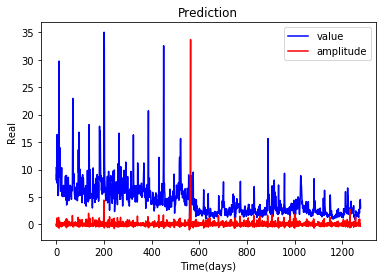

In [6]:
count = len(volume_data)
min_ = 1
max_ = 0
stat = []
sc = MinMaxScaler()
volume_data_temp = sc.getScalerData(volume_data, offset=0, feature_range=(0, 35))
for i in range(1, count):
    temp = (volume_data[i] - volume_data[i-1]) / volume_data[i-1]
    stat.append(temp[0])
    if temp > max_:
        max_ = temp
    elif temp < min_:
        min_ = temp
print(max_, min_)

# Visualising the results
plt.plot(volume_data_temp, color = 'blue', label = 'value')
plt.plot(stat, color = 'red', label = 'amplitude')
plt.title('Prediction')
plt.xlabel('Time(days)')
plt.ylabel('Real')
plt.legend()
plt.show()

# Create Model

In [7]:
# LSTM Training
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten
from tensorflow.keras.utils import plot_model

model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (input_days, 2), dropout=0.2))
model.add(LSTM(units = 50, return_sequences = True, dropout=0.2))
model.add(Flatten())
model.add(Dense(units = 128, activation='relu'))
model.add(Dense(units = 40, activation='relu'))
model.add(Dense(units = 1))
model.compile(optimizer = optimizer, loss = 'mean_squared_error')
model.summary()
plot_model(model, 'model.png')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 50)            10600     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 50)            20200     
_________________________________________________________________
flatten (Flatten)            (None, 500)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               64128     
_________________________________________________________________
dense_1 (Dense)              (None, 40)                5160      
_______________________________________

# Training the model with `Open` data and `Volume` data

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os
name = 'LSTM_03'
checkpoint_file = './model/' + name + '_check_point/cp-{epoch:04d}.ckpt'
try:
    os.mkdir('./model/' + name + '_check_point/')
except:
    pass

# get what we want
train_input = train_x
train_label = train_y
test_input = test_x
test_label = test_y
train_label = np.squeeze(train_label, axis=1)
test_label = np.squeeze(test_label, axis=1)

# create callback function
cp_callback = ModelCheckpoint(checkpoint_file, save_weights_only=True, verbose=1, period=period)

# train the model
train = model.fit(train_input, train_label, epochs=epochs, batch_size=batch_size, callbacks=[cp_callback], 
                  validation_data=(test_input, test_label))

# save model
model.save('./model/' + name + '.h5')

Train on 1248 samples, validate on 30 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
1248/1248 [==============================] - 2s 2ms/sample - loss: 0.6088 - val_loss: 1.1964
Epoch 2/1000
1248/1248 [==============================] - 0s 88us/sample - loss: 0.4872 - val_loss: 1.0721
Epoch 3/1000
1248/1248 [==============================] - 0s 88us/sample - loss: 0.4000 - val_loss: 0.9719
Epoch 4/1000
1248/1248 [==============================] - 0s 88us/sample - loss: 0.3310 - val_loss: 0.8853
Epoch 5/1000
1248/1248 [==============================] - 0s 88us/sample - loss: 0.2753 - val_loss: 0.8148
Epoch 6/1000
1248/1248 [==============================] - 0s 88us/sample - loss: 0.2325 - val_loss: 0.7576
Epoch 7/1000
1248/1248 [==============================] - 0s 88us/sample - loss: 0.2015 - val_loss: 0.7129
Epoch 8/1000
1248/1248 [==============================] - 0s 88us/sample - loss: 0.1763 - val_loss: 0.6772
Epoch 9/1000
1248/1248 [===========================

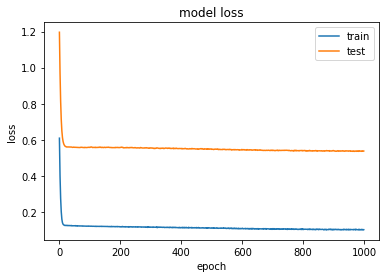

In [9]:
plt.plot(train.history['loss'])
plt.plot(train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [12]:
# local data
# model.load_weights('./model/LSTM_03_check_point/cp-{epoch:04d}.ckpt'.format(epoch=600))
if local_norm_flag:
    testing_data = open_data[-test_count-input_days:]
    output_prices = []
    for i in range(test_count):
        sc = MinMaxScaler()
        test = testing_data[i:i+input_days]
        test = sc.getScalerData(test, offset=offset)
        output = model.predict(np.append(np.expand_dims(test, axis=0), test_x[i:i+1, :, 1:2], axis=-1))
        output_prices.append(sc.getInverseData(output[0][0]))
else:
    output = model.predict(test_input)
    output_qute = 1 + open_sc.getInverseData(output)[-test_count:]
    value_init = open_data[-test_count-1:-1]
    output_prices = value_init * output_qute
output_prices = np.asarray(output_prices)
print(output_prices.shape, output_prices)

(20,) [319.61041309 320.48669415 321.58558839 312.70136309 306.67996973
 304.35984528 301.40149357 299.42348053 300.14516567 301.89968084
 304.92084684 307.9695063  290.34068517 291.68974358 294.40762677
 299.4737228  300.55302817 302.22012037 302.90644198 303.3491701 ]


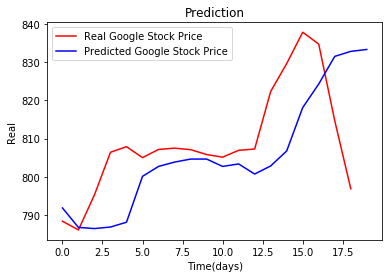

In [11]:
# Visualising the results
plt.plot(test_data_t[1:, 0], color = 'red', label = 'Real Google Stock Price')
plt.plot(output_prices, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Prediction')
plt.xlabel('Time(days)')
plt.ylabel('Real')
plt.legend()
plt.show()

In [18]:
# local data
# model.load_weights('./model/LSTM_03_check_point/cp-{epoch:04d}.ckpt'.format(epoch=600))

train_count = len(train_data_t) - input_days
if local_norm_flag:
    testing_data = open_data[:-test_count]
    output_prices = []
    for i in range(train_count):
        sc = MinMaxScaler()
        test = testing_data[i:i+input_days]
        test = sc.getScalerData(test, offset=offset)
        output = model.predict(np.append(np.expand_dims(test, axis=0), train_x[i:i+1, :, 1:2], axis=-1))
        output_prices.append(sc.getInverseData(output[0][0]))
output_prices = np.asarray(output_prices)
print(output_prices.shape, output_prices)

(1248,) [320.21771833 321.05380907 322.04292328 ... 796.08553921 795.77559688
 791.97799407]


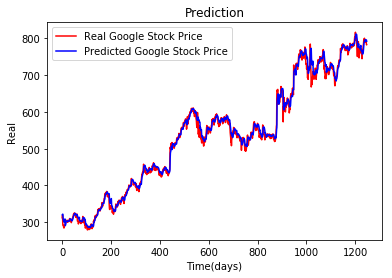

In [20]:
# Visualising the results
if local_norm_flag:
    plt.plot(train_data_t[input_days:, 0], color = 'red', label = 'Real Google Stock Price')
    plt.plot(output_prices, color = 'blue', label = 'Predicted Google Stock Price')
    plt.title('Prediction')
    plt.xlabel('Time(days)')
    plt.ylabel('Real')
    plt.legend()
    plt.show()